In [1]:
import jax.numpy as jnp
from jax import random, grad, jit
from jax.scipy.linalg import inv, svd, eigh, det

from jax.lax import scan
import jax
from scipy.linalg import solve_discrete_are
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial


key = random.PRNGKey(3)

# System dimensions
n = 40  # System dimension
p = 2  # Observation dimension
num_steps = 1000 # number of steps
J0 = 0 # burn in period
N = 10 # Monte Carlo samples

def create_stable_matrix(n, key):
    # Generate a symmetric random matrix
    A = random.normal(key, (n, n))
    A = (A + A.T) / 2
    
    # Ensure the matrix has a spectral radius < 1 for stability
    eigenvalues, eigenvectors = eigh(A)
    scaled_eigenvalues = eigenvalues / (jnp.abs(eigenvalues).max() + 0.1)  # Scale eigenvalues to ensure stability
    A_stable = eigenvectors @ jnp.diag(scaled_eigenvalues) @ eigenvectors.T
    
    return A_stable

# Model parameters
m0 = jnp.ones((n,))
C0 = jnp.eye(n) * 1.0   # Initial state covariance matrix (P)
Q = jnp.eye(n) * 5.0    # Process noise covariance matrix (Sigma in Julia code)
R = jnp.eye(n) * 1.0    # Observation noise covariance matrix (Gamma)
inv_R = inv(R)
M = create_stable_matrix(n,key)    # State transition matrix (A)
H = jnp.eye(n)          # Observation matrix
observation_interval = 1

# State initialization
vd0 = m0 + random.multivariate_normal(key, jnp.zeros(n), C0)


key, _ = random.split(key)


def state_transition_function(x):
    return jnp.dot(M, x)

A_step = Partial(state_transition_function)


In [2]:
from jax_vi import KL_gaussian, log_likelihood, KL_sum
from jax_filters import apply_filtering_fixed_linear
from jax_models import visualize_observations, Lorenz96, generate_true_states, generate_gc_localization_matrix



In [3]:
observations, true_states = generate_true_states(key, num_steps, n, vd0, H, Q, R, A_step, observation_interval)

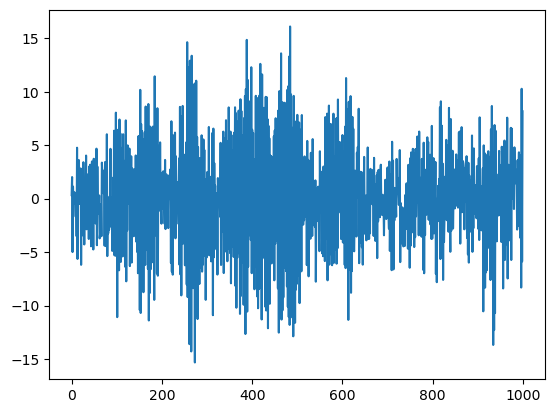

In [4]:
plt.plot(true_states[:,0:1])

In [5]:
from functools import partial


@partial(jit, static_argnums=(3,10))
def var_cost(K, m0, C0, n, M, H, Q, R, y, key, N, num_steps, J0):
    states, covariances = apply_filtering_fixed_linear(m0, C0, y, K, n, M, H, Q, R)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(states, covariances, n, A_step, Q, key, N)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, states, covariances), y, H, R, num_steps, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    
    return cost


In [6]:

P = solve_discrete_are(M.T, H.T, Q, R)
# Compute steady-state Kalman gain K
K_steady = P @ H.T @ jnp.linalg.inv(H @ P @ H.T + R)
print("Steady-state K:")
print(K_steady)

# Define the gradient of the cost function
var_cost_grad = grad(var_cost, argnums=0)



# Initial guess for K and optimization parameters
K_opt = jnp.eye(n) * 0.4
alpha = 1e-5


Steady-state K:
[[ 8.40266705e-01 -5.55823965e-04  1.92276877e-03 ... -1.73811219e-03
   1.11666966e-04  8.76734848e-04]
 [-5.55823499e-04  8.39133441e-01  6.72232360e-04 ...  4.67147242e-04
   4.21348494e-04  1.22993370e-03]
 [ 1.92276668e-03  6.72233349e-04  8.39998186e-01 ... -1.18181913e-03
  -6.40447659e-04  2.05435441e-03]
 ...
 [-1.73810951e-03  4.67148668e-04 -1.18181854e-03 ...  8.39636028e-01
  -1.19427976e-03  1.84438261e-03]
 [ 1.11666755e-04  4.21350444e-04 -6.40445971e-04 ... -1.19427964e-03
   8.41578901e-01  6.41926192e-04]
 [ 8.76733684e-04  1.22993300e-03  2.05434952e-03 ...  1.84438145e-03
   6.41926250e-04  8.38967323e-01]]


  0%|          | 0/100 [00:00<?, ?it/s]

[[-9.5731631e+03  3.3721445e+02 -7.6791626e+02 ...  8.2517224e+02
  -1.7729399e+02 -1.4664862e+02]
 [ 3.8092105e+02 -8.4799834e+03  1.7481361e+02 ...  2.1301355e+02
  -7.3323891e+01 -4.2368317e-01]
 [-7.8873596e+02  2.4161554e+02 -9.2890361e+03 ...  1.5743953e+02
   3.0439069e+02 -5.2037689e+02]
 ...
 [ 8.3706641e+02  5.6591549e+01  2.5641330e+02 ... -8.5972266e+03
   1.7593898e+02 -5.2789001e+02]
 [-1.8078978e+02 -2.1434406e+02  3.7397720e+02 ...  1.7533939e+02
  -9.4152939e+03 -3.0170087e+02]
 [-1.9926331e+02  1.9194412e+01 -4.7339166e+02 ... -5.4126099e+02
  -3.8856262e+02 -8.7650732e+03]]
[[-6.2681816e+03  2.1853834e+01 -2.6283903e+01 ...  1.8645969e+02
  -1.4208211e+02  1.1739716e+02]
 [ 2.3711276e+00 -5.9887227e+03  3.5360168e+01 ...  2.4223915e+02
   4.5424068e+01  9.8380013e+00]
 [-1.3476534e+02  8.9170540e+01 -6.1336694e+03 ... -9.0510864e+01
   5.3374962e+01 -7.6466248e+01]
 ...
 [ 2.4933273e+02  1.8968869e+02  5.6956684e+01 ... -6.1075718e+03
  -1.2950197e+01 -2.2625800e+02]

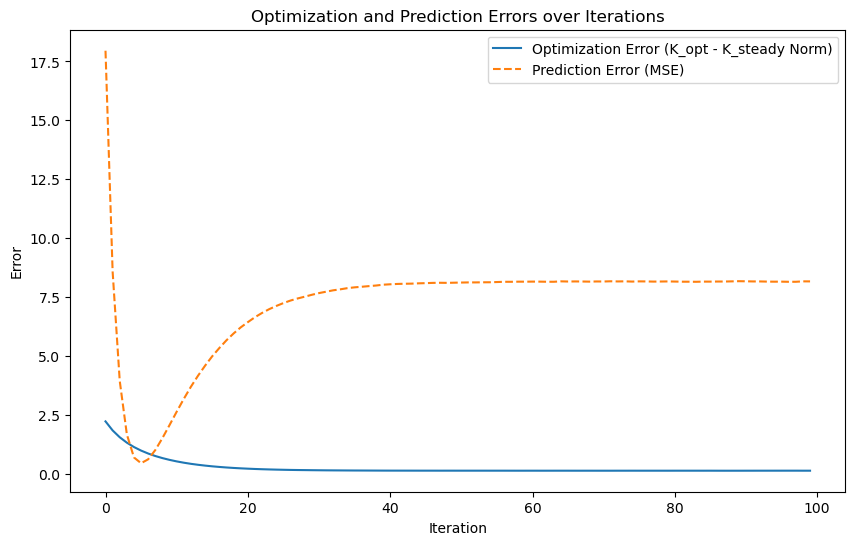

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy import linalg as jnpl
from tqdm.auto import tqdm



prediction_errors = [] 
errs = []

for i in tqdm(range(100)):
    key, _ = random.split(key)
    # Update the gradient and Kalman gain
    grad_K = var_cost_grad(K_opt, m0, C0, n, M, H, Q, R, observations, key, N, num_steps, J0)
    K_opt -= alpha * grad_K
    print(grad_K)
    
    # Apply filtering with the newly optimized K to generate state predictions
    predicted_states, _ = apply_filtering_fixed_linear(m0, C0, observations, K_opt, n, M, H, Q, R)
    
    prediction_error = jnpl.norm(predicted_states - true_states) ** 2 / len(true_states)
    prediction_errors.append(prediction_error)
    errs.append(jnpl.norm(K_opt - K_steady))

# Plotting both optimization error and prediction error
plt.figure(figsize=(10, 6))
plt.plot(errs, label='Optimization Error (K_opt - K_steady Norm)')
plt.plot(prediction_errors, label='Prediction Error (MSE)', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Optimization and Prediction Errors over Iterations')
plt.legend()
plt.show()
